In [17]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [18]:
model_error_args = {
    "nx": 700,
    "ny": 500,
    "dx": 300.0,
    "dy": 300.0,
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }

model_error_args_coarse = {
    "nx": 70,
    "ny": 50,
    "dx": 3000.0,
    "dy": 3000.0,
    "gpu_ctx": gpu_ctx,
    "gpu_stream": gpu_stream,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
    }


sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

def make_init_fields(args):
    dataShape = (args["ny"] + 4, args["nx"] + 4)
    dataShapeH = (args["ny"] + 5, args["nx"] + 5)

    eta = np.zeros(dataShape, dtype=np.float32)
    hu  = np.zeros(dataShape, dtype=np.float32)
    hv  = np.zeros(dataShape, dtype=np.float32)
    Hi = np.ones(dataShapeH, dtype=np.float32)*60

    return {"eta": eta, "hu": hu, "hv": hv, "Hi": Hi}

def imshow(data):
    fig = plt.figure()
    plt.imshow(data, origin="lower")
    plt.colorbar()

def imshowDataArgs(data_args):
    imshow3(data_args["eta"], data_args["hu"], data_args["hv"])

def imshowSim(sim):
    eta, hu, hv = sim.download(interior_domain_only=False)
    imshow3(eta, hu, hv)

def imshow3(eta, hu, hv):
    fig, axs = plt.subplots(1,3, figsize=(12,3))
    eta_im = axs[0].imshow(eta[2:-2, 2:-2], origin="lower")
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])

    hu_im = axs[1].imshow(hu[2:-2, 2:-2], origin="lower")
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    hv_im = axs[2].imshow(hv[2:-2, 2:-2], origin="lower")
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    


In [5]:
reload(ModelErrorKL)

mekl = ModelErrorKL.ModelErrorKL(**model_error_args, include_sin=True) #, basis_x_end=1, basis_y_end=1)

In [43]:
data_args = make_init_fields(model_error_args)
#mekl.perturbEtaCPU(data_args["eta"])


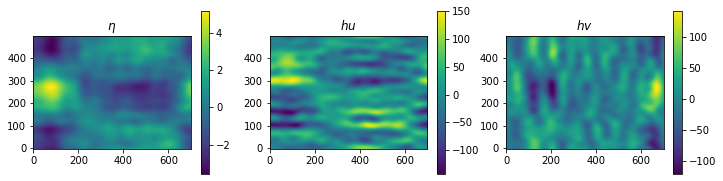

In [7]:
mekl.perturbOceanStateCPU(**data_args, **sample_args)
imshowDataArgs(data_args)

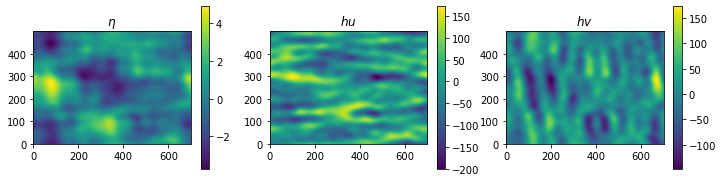

In [8]:
mekl.perturbOceanStateCPU(**data_args, **sample_args)
imshowDataArgs(data_args)

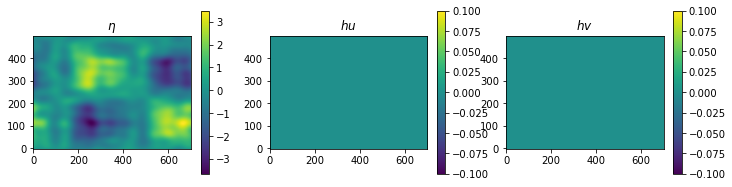

In [45]:
mekl.perturbEtaCPU(data_args["eta"])
imshowDataArgs(data_args)

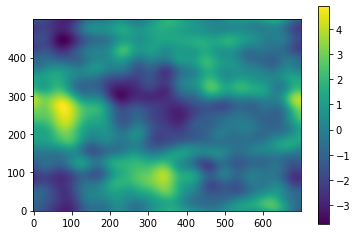

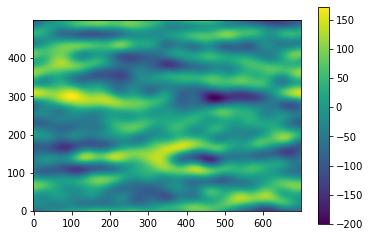

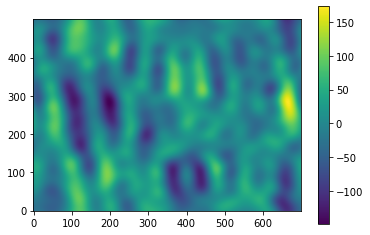

In [9]:
#for i in range(100):
#    mekl.perturbOceanStateCPU(**data_args, **sample_args)

imshow(data_args["eta"][2:-2, 2:-2])
imshow(data_args["hu"][2:-2, 2:-2])
imshow(data_args["hv"][2:-2, 2:-2])

### Test perturbing two ocean states with different resolution 

In [39]:
reload(ModelErrorKL)
fine_data_args = make_init_fields(model_error_args)
fine_mekl = ModelErrorKL.ModelErrorKL(**model_error_args, include_sin=False) #, basis_x_end=1, basis_y_end=1)

coarse_data_args = make_init_fields(model_error_args_coarse)
coarse_mekl = ModelErrorKL.ModelErrorKL(**model_error_args_coarse, include_sin=False) #, basis_x_end=1, basis_y_end=1)

roll_fine = {
    "roll_x_sin": 0, #50,
    "roll_y_sin": 0, #340,
    "roll_x_cos": 0, #480,
    "roll_y_cos": 0, #160,
}
roll_coarse = {
    "roll_x_sin": 0, #5,
    "roll_y_sin": 0, #34,
    "roll_x_cos": 0, #40,
    "roll_y_cos": 0, #16,
}

In [40]:
fine_mekl.perturbOceanStateCPU(**fine_data_args, **sample_args, **roll_fine)


In [41]:
coarse_mekl.perturbOceanStateCPU(**coarse_data_args, **sample_args, **roll_coarse,
                                 random_numbers=fine_mekl.random_numbers_host)

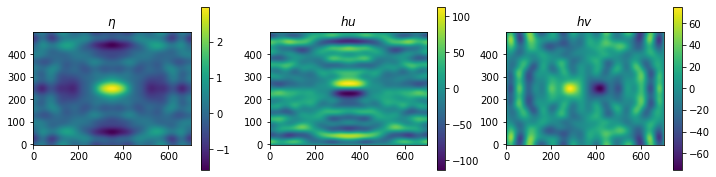

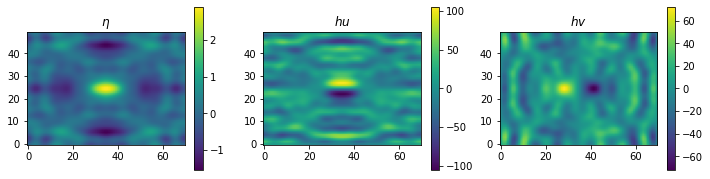

In [42]:
imshowDataArgs(fine_data_args)
imshowDataArgs(coarse_data_args)

In [13]:
fine_data_args["eta"].shape, coarse_data_args["eta"].shape

((504, 704), (54, 74))

# Start sim with one of these states 

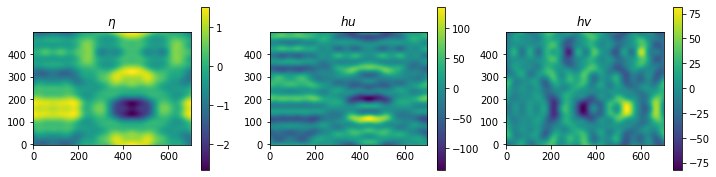

In [28]:
sim_args = {
    "gpu_ctx" : gpu_ctx,
    "nx" : model_error_args["nx"],
    "ny" : model_error_args["ny"],
    "dx" : model_error_args["dx"],
    "dy" : model_error_args["dy"],
    "f"  : sample_args["f"],
    "g"  : sample_args["g"],
    "r"  : 0,
    "dt" : 0,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2),
    "eta0" : fine_data_args["eta"],
    "hu0"  : fine_data_args["hu"],
    "hv0"  : fine_data_args["hv"],
    "H"    : fine_data_args["Hi"],
}

sim = CDKLM16.CDKLM16(**sim_args)
imshowSim(sim)


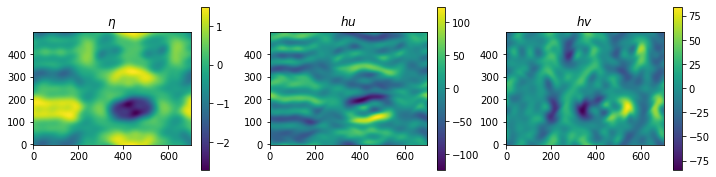

In [29]:
sim.step(10000)
imshowSim(sim)

# GPU 